<a href="https://colab.research.google.com/github/ar3s27/GlobalAiHub-Project/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import cv2
import random
import time
import os

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
df = pd.read_csv('/content/drive/MyDrive/GlobalAiHub/UrbanSound8K.csv')
df.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [35]:
!unzip '/content/drive/MyDrive/GlobalAiHub/spectrograms.zip'

Archive:  /content/drive/MyDrive/GlobalAiHub/spectrograms.zip
replace spectrograms/5/94710-5-0-1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [74]:
imgs= []
labels= []
for ticket in range(10):
  img_array=os.listdir("/content/spectrograms/"+str(ticket))  

  for img_iter in range(len(img_array)):
    img_gray=cv2.imread("/content/spectrograms/"+str(ticket)+"/"+img_array[img_iter],0)

    resized_gray = cv2.resize(img_gray, (100, 100), interpolation = cv2.INTER_AREA)
    normalized_gray=resized_gray/255
    
    imgs.append(normalized_gray)
    labels.append(ticket)

In [75]:
dict_ = list(zip(imgs, labels))
random.seed(10)
random.shuffle(dict_)
imgs, labels = zip(*dict_)

In [76]:
imgs=np.array(imgs)
labels=np.array(labels)

In [77]:
def train_valid_test(imgs, labels, train_percentage = 0.7, valid_percentage = 0.15):
  size=len(imgs)

  X_train=imgs[:int(train_percentage*size)]
  X_val=imgs[int(train_percentage*size):int((train_percentage+valid_percentage)*size)]
  X_test=imgs[int((train_percentage+valid_percentage)*size):]

  y_train=labels[:int(train_percentage*size)]
  y_val=labels[int(train_percentage*size):int((train_percentage+valid_percentage)*size)]
  y_test=labels[int((train_percentage+valid_percentage)*size):]

  return X_train, y_train, X_val, y_val, X_test, y_test

In [78]:
X_train, y_train, X_val, y_val, X_test, y_test= train_valid_test(imgs, labels)

In [79]:
print(f"X_train: {len(X_train)}")
print(f"X_val: {len(X_val)}")
print(f"X_test: {len(X_test)}")
print(f"y_train: {len(y_train)}")
print(f"y_val: {len(y_val)}")
print(f"y_test: {len(y_test)}")

X_train: 6112
X_val: 1310
X_test: 1310
y_train: 6112
y_val: 1310
y_test: 1310


In [73]:
np.save('/content/drive/MyDrive/GlobalAiHub/X_train.npy', X_train)
np.save('/content/drive/MyDrive/GlobalAiHub/X_val.npy', X_val)
np.save('/content/drive/MyDrive/GlobalAiHub/X_test.npy', X_test)
np.save('/content/drive/MyDrive/GlobalAiHub/y_train.npy', y_train)
np.save('/content/drive/MyDrive/GlobalAiHub/y_val.npy', y_val)
np.save('/content/drive/MyDrive/GlobalAiHub/y_test.npy', y_test)

In [72]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu",
                                 input_shape=(100,100,1))) 
model.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(128,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="valid",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [38]:
model.compile(optimizer="adam",metrics=["accuracy"], loss="sparse_categorical_crossentropy")


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 67712)             0

In [40]:
results=model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
24/24 [==============================] - 231s 10s/step - loss: 2.2811 - accuracy: 0.1401 - val_loss: 2.1057 - val_accuracy: 0.2817
Epoch 2/20
24/24 [==============================] - 211s 9s/step - loss: 2.1048 - accuracy: 0.2081 - val_loss: 1.8994 - val_accuracy: 0.2901
Epoch 3/20
24/24 [==============================] - 211s 9s/step - loss: 1.9531 - accuracy: 0.2538 - val_loss: 1.6761 - val_accuracy: 0.4511
Epoch 4/20
24/24 [==============================] - 214s 9s/step - loss: 1.7806 - accuracy: 0.3298 - val_loss: 1.5082 - val_accuracy: 0.5237
Epoch 5/20
24/24 [==============================] - 210s 9s/step - loss: 1.6499 - accuracy: 0.3878 - val_loss: 1.3303 - val_accuracy: 0.5496
Epoch 6/20
24/24 [==============================] - 211s 9s/step - loss: 1.5104 - accuracy: 0.4339 - val_loss: 1.2136 - val_accuracy: 0.6031
Epoch 7/20
24/24 [==============================] - 213s 9s/step - loss: 1.3836 - accuracy: 0.4849 - val_loss: 1.0895 - val_accuracy: 0.6725
Epoch 8/20
2

In [42]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8572518825531006


In [43]:
train_loss_score=model.evaluate(X_train,y_train,verbose=0)
test_loss_score=model.evaluate(X_test,y_test,verbose=0)
print(train_loss_score)
print(test_loss_score)

[0.288913756608963, 0.9198298454284668]
[0.49827009439468384, 0.8572518825531006]


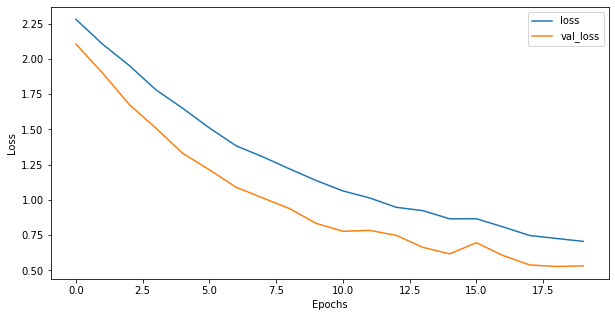

In [54]:
plt.figure(figsize=(10,5))
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

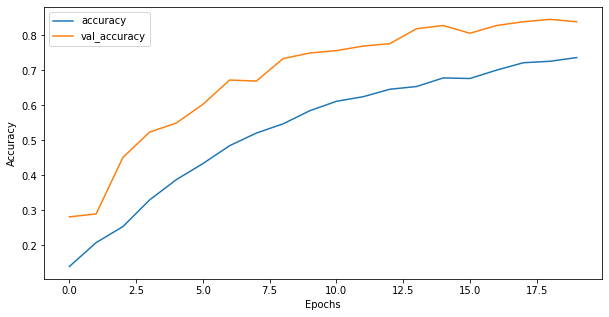

In [55]:
plt.figure(figsize=(10,5))
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [50]:
model.evaluate(X_test,y_test)

41/41 [==============================] - 12s 303ms/step - loss: 0.4983 - accuracy: 0.8573


[0.49827009439468384, 0.8572518825531006]

In [65]:
test_result = model.test_on_batch(X_test, y_test)

In [67]:
print(f"Loss: {test_result[0]}, Prediction probability: {test_result[1]}")

Loss: 0.5410500764846802, Prediction probability: 0.8458015322685242
